# Create context-specific models - DeepRed Omics data
## Setup
### Import packages

In [1]:
import re
import shutil
import tempfile
import zipfile
from collections import Counter, defaultdict
from pathlib import Path
from warnings import warn

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mpl_venn
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    handle_msg,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    ProteinDilution,
    add_relaxation_budget,
    create_protein_dilution_df,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL
from sklearn.metrics import r2_score

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664191

Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e-8, 1e8)
COBRA_CONFIGURATION.tolerance = 1e-9
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-09
lower_bound,Default reaction lower bound,-1e-08
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRed"

### Set variables for columns keys and sample identification

In [4]:
sample_key = "SAMPLE ID"

### Set computation options

In [5]:
run_computations = True  # Keep off to use previously computed results
overwrite = True  # Whether to allow overwriting of previous simulation results
verbose = True
objective_reactions = (
    []
)  # Objective reactions are used to determine slack variable but not necessary

### Set figure options

In [6]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [7]:
# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (
    get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name
)
fitting_dirpath = results_dirpath / "fitting"
# Ensure directories exist
results_dirpath.mkdir(exist_ok=True, parents=True)
fitting_dirpath.mkdir(exist_ok=True, parents=True)
# ZIP directories
sample_pcmodels_dirpath = results_dirpath / "pcmodels"

### Define hemoglobin proteins

In [8]:
HB_PROTEINS = {
    "HBA": "P69905",  # Hemoglobin subunit alpha
    "HBB": "P68871",  # Hemoglobin subunit beta
    "HBD": "P02042",  # Hemoglobin subunit delta
    "HBE1": "P02100",  # Hemoglobin subunit beta
    "HBG1": "P69891",  # Hemoglobin subunit gamma-1
    "HBG2": "P69892",  # Hemoglobin subunit gamma-2
    "HBM": "Q6B0K9",  # Hemoglobin subunit mu
    "HBQ1": "P09105",  # Hemoglobin subunit theta-1
    "HBZ": "P02008",  # Hemoglobin subunit zeta
}

## Load RBC-GEM models

In [9]:
# Load models
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=model_dirpath / f"{model_id}_PC.xml")

pcmodel

Name,RBC_GEM_PC
Memory address,1f6f29ff750
Number of metabolites,7784
Number of reactions,14900
Number of genes,723
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load copy numbers and protein data

In [10]:
# Load protein copy numbers
df_copy_numbers = pd.read_csv(
    processed_data_dirpath / "ProteinCopyNumbers.csv",
    index_col=sample_key,
)

# Load protein data
df_protein_data = pd.read_csv(
    processed_data_dirpath / "ProteinData.csv",
    index_col="Entry",
)


sample_ids = list(df_copy_numbers.index.unique())
handle_msg(f"Number of measured samples: {len(sample_ids)}", print_msg=True)

df_copy_numbers

Number of measured samples: 1


,A0A024RBG1,A0A075B6I9,A0A075B6K5,A0A075B6P5,A0A075B6R9,A0A075B6S2,A0A0A0MRZ8,A0A0C4DH25,A0A0C4DH41,A0A1W2PR19,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6N5,Q9Y6P5,Q9Y6R4,Q9Y6U3,Q9Y6W3,Q9Y6W5,Q9Y6Y8
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,
DeepRed,4721.116599,15021.40978,609.550609,38381.33516,3124.21758,6557.865957,10352.39291,2136.1758,2177.580856,1706.116041,...,321.00004,29094.65457,307431.0413,689.048171,5653.931616,103.500561,655.143138,7630.705577,52631.87621,8313.38099


## Integrate proteomics with model
### Scale measurements for proteome budget
Note that this step will help ensure its theoretically possible for a perfect fit 

In [11]:
HB_PERCENT, LA_PERCENT = (0.95, 0.05)
MODELED_PERCENT = HB_PERCENT + LA_PERCENT
assert 1 >= MODELED_PERCENT

budget_hb_value = 1000 * HB_PERCENT
budget_la_value = 1000 * LA_PERCENT
budget_total_value = 1000 * MODELED_PERCENT

handle_msg(f"Hemoglobin budget:\t{budget_hb_value} mg protein / gDW", print_msg=True)
handle_msg(f"Low abundance budget:\t{budget_la_value} mg protein / gDW", print_msg=True)
handle_msg(f"Total budget:\t\t{budget_total_value} mg protein / gDW", print_msg=True)

Hemoglobin budget:	950.0 mg protein / gDW
Low abundance budget:	50.0 mg protein / gDW
Total budget:		1000.0 mg protein / gDW


### Convert copy numbers to mg / gDW

In [12]:
df_uniprot_to_mw = df_protein_data["Mass"].astype(float)
gDW_total_protein = DEFAULT_DRY_MASS_PER_CELL * (  # pgDW total protein / cell
    1 / 1e12
)  #  gDW total protein / pgDW total protein  # gDW total protein / cell
df_mg_prot_per_gDW = (
    df_copy_numbers[df_protein_data.index].mul(  # protein copies / cell
        1 / gDW_total_protein, axis=0  # cell / gDW total protein
    )
    * (
        1
        / AVOGADRO_NUMBER  # mol protein / protein copies
        * df_uniprot_to_mw  # gDW protein / mol protein
        * 1e3  # mgDW protein / gDW protein
    ).copy()
)  # mgDW protein / gDW total protein
df_mg_prot_per_gDW = df_mg_prot_per_gDW.loc[df_copy_numbers.index]
df_mg_prot_per_gDW[df_mg_prot_per_gDW.index.duplicated()]

,A0A024RBG1,A0A075B6I9,A0A075B6K5,A0A075B6P5,A0A075B6R9,A0A075B6S2,A0A0A0MRZ8,A0A0C4DH25,A0A0C4DH41,A0A1W2PR19,...,Q9Y6M1,Q9Y6M4,Q9Y6M5,Q9Y6N5,Q9Y6P5,Q9Y6R4,Q9Y6U3,Q9Y6W3,Q9Y6W5,Q9Y6Y8
SAMPLE ID,,,,,,,,,,,,,,,,,,,,,


In [13]:
# Split into hemoglobin and low abundance proteomes
budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]
df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW.loc[
    :, df_mg_prot_per_gDW.columns.isin(HB_PROTEINS.values())
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW.loc[
    :, ~df_mg_prot_per_gDW.columns.isin(HB_PROTEINS.values())
]

df_summary = {
    "Perfect total": 1000,
    "Current total": df_mg_prot_per_gDW.loc[sample_ids].sum(axis=1).mean().item(),
    "Hemoglobin total": df_mg_prot_per_gDW_hb.loc[sample_ids].sum(axis=1).mean().item(),
    "Low abundance total": df_mg_prot_per_gDW_la.loc[sample_ids]
    .sum(axis=1)
    .mean()
    .item(),
}
df_summary["Remaining/Excess"] = df_summary["Perfect total"] - (
    df_summary["Hemoglobin total"] + df_summary["Low abundance total"]
)

budget_rxn_proteome = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}proteome"
)
budget_rxn_hemoglobin = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}hemoglobin"
)
budget_rxn_total = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}total"
)

if budget_la_value is None:
    budget_la_value = budget_rxn_proteome.upper_bound
if budget_hb_value is None:
    budget_hb_value = budget_rxn_hemoglobin.upper_bound
if budget_total_value is None:
    budget_total_value = budget_rxn_total.upper_bound

assert budget_total_value >= (budget_la_value + budget_hb_value)

budget_rxn_proteome.upper_bound = budget_la_value
budget_rxn_hemoglobin.upper_bound = budget_hb_value
budget_rxn_total.upper_bound = budget_total_value

# Scale values for low abundance proteome
budget_value = budget_la_value
df_mg_prot_per_gDW_la = (
    budget_value * (df_mg_prot_per_gDW_la.T / df_mg_prot_per_gDW_la.sum(axis=1)).T
)
df_summary["Low abundance scaled"] = budget_value

# Scale values for hemoglobin proteome
budget_value = budget_hb_value
df_mg_prot_per_gDW_hb = (
    budget_value * (df_mg_prot_per_gDW_hb.T / df_mg_prot_per_gDW_hb.sum(axis=1)).T
)
df_summary["Hemoglobin scaled"] = budget_value

budget_value = budget_total_value - sum([budget_la_value, budget_hb_value])
df_summary["Remaining scaled"] = budget_value

# Combine dataframes back into one
df_mg_prot_per_gDW_normalized = pd.concat(
    (df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la), axis=1
)
df_summary = pd.DataFrame.from_dict(
    {
        " " * max(30 - len(k), 0) + k: [f"{v:.4f}", f"{v / 1000 * 100:.1f}%"]
        for k, v in df_summary.items()
    },
    orient="index",
    columns=["mg protein / gDW / cell", "Percentage"],
)
print(df_summary)
df_mg_prot_per_gDW_normalized.sum(axis=1)

                     mg protein / gDW / cell Percentage
       Perfect total               1000.0000     100.0%
       Current total               2039.5138     204.0%
    Hemoglobin total                398.5474      39.9%
 Low abundance total               1640.9664     164.1%
    Remaining/Excess              -1039.5138    -104.0%
Low abundance scaled                 50.0000       5.0%
   Hemoglobin scaled                950.0000      95.0%
    Remaining scaled                  0.0000       0.0%


SAMPLE ID
DeepRed    1000.0
dtype: float64

### Convert mg / gDW to nmol / gDW

In [14]:
df_nmol_prot_per_gDW = (
    df_mg_prot_per_gDW_normalized  # mg / gDW
    * (1 / df_uniprot_to_mw)  # mol / g --> mmol / mg
    * (1e6 / 1)  # nmol / mmol
).loc[:, df_mg_prot_per_gDW_normalized.columns]
df_nmol_prot_per_gDW = df_nmol_prot_per_gDW.T
df_nmol_prot_per_gDW

SAMPLE ID,DeepRed
P02008,571.499749
P02042,11681.914037
P02100,3835.038390
P09105,83.511852
P68871,17545.633065
...,...
Q9Y6R4,0.000175
Q9Y6U3,0.001105
Q9Y6W3,0.012870
Q9Y6W5,0.088766


## Create DataFrame for protein dilution reactions

In [15]:
df_model_protein_dilutions = create_protein_dilution_df(pcmodel)
df_model_protein_dilutions

,genes,PROTDL
uniprot,,
Q9NRN7,AASDHPPT,PROTDL_protein_AASDHPPT_pc
O95477,ABCA1,PROTDL_protein_ABCA1_pc
Q8IZY2,ABCA7,PROTDL_protein_ABCA7_pc
P08183,ABCB1,PROTDL_protein_ABCB1_pc
P21439,ABCB4,PROTDL_protein_ABCB4_pc
...,...,...
P07947,YES1,PROTDL_protein_YES1_pc
Q5W0Z9,ZDHHC20,PROTDL_protein_ZDHHC20_pc
Q9UIJ5,ZDHHC2,PROTDL_protein_ZDHHC2_pc


## Organize samples (optional)
Use this for organizing samples if time-outs are an issue or multiple runs are necessary

In [16]:
df_samples = df_nmol_prot_per_gDW.copy()
df_samples

SAMPLE ID,DeepRed
P02008,571.499749
P02042,11681.914037
P02100,3835.038390
P09105,83.511852
P68871,17545.633065
...,...
Q9Y6R4,0.000175
Q9Y6U3,0.001105
Q9Y6W3,0.012870
Q9Y6W5,0.088766


### Map samples to model

In [17]:
merge_key = "uniprot"
df_samples.index.name = merge_key

df_model = (
    df_model_protein_dilutions[["PROTDL"]]
    .merge(df_samples, left_index=True, right_index=True, how="left")
    .set_index("PROTDL")
    .sort_index()
)
no_experimental_measurements = [
    protein_dilution
    for protein_dilution, has_measurement in df_model.isna().all(axis=1).items()
    if has_measurement
]
handle_msg(
    f"Model proteins mapped to measurements: {len(df_model) - len(no_experimental_measurements)}",
    print_msg=True,
)
handle_msg(
    f"Model proteins without measurements: {len(no_experimental_measurements)}",
    print_msg=True,
)
df_model.dropna()

Model proteins mapped to measurements: 635
Model proteins without measurements: 88


,DeepRed
PROTDL,
PROTDL_protein_AASDHPPT_pc,0.120440
PROTDL_protein_ABCA7_pc,0.010758
PROTDL_protein_ABCB4_pc,0.000703
PROTDL_protein_ABCB6_pc,0.400265
PROTDL_protein_ABCC1_pc,0.062802
...,...
PROTDL_protein_YES1_pc,0.029320
PROTDL_protein_ZDHHC20_pc,0.062300
PROTDL_protein_ZDHHC2_pc,0.016674


#### Summarize mapping

In [18]:
dataset_proteins = set(df_samples.index)
model_proteins = set(df_model_protein_dilutions.index)

df_mg_prot_per_gDW_hb = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [
        x
        for x in df_mg_prot_per_gDW_normalized.columns
        if x in list(HB_PROTEINS.values())
    ],
]
df_mg_prot_per_gDW_la = df_mg_prot_per_gDW_normalized.loc[
    [
        x for x in df_mg_prot_per_gDW_normalized.index if x in sample_ids
    ],  # Don't include operation IDs
    [x for x in df_mg_prot_per_gDW.columns if not x in list(HB_PROTEINS.values())],
]

df_mapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_la = df_mg_prot_per_gDW_la.loc[
    :, ~df_mg_prot_per_gDW_la.columns.isin(model_proteins)
].sum(axis=1)
df_mapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)
df_unmapped_mass_hb = df_mg_prot_per_gDW_hb.loc[
    :, ~df_mg_prot_per_gDW_hb.columns.isin(model_proteins)
].sum(axis=1)

proteomes = {}
round_int = 6
for label, df in zip(
    ["hemoglobin", "low abundance"], [df_mg_prot_per_gDW_hb, df_mg_prot_per_gDW_la]
):
    df_modeled = df.loc[:, df.columns.isin(model_proteins)].sum(axis=1)
    df_remaining = df.loc[:, ~df.columns.isin(model_proteins)].sum(axis=1)
    means = (df_modeled.mean(), df_remaining.mean())
    stdevs = (df_modeled.std(), df_remaining.std())
    proteomes[(label, "modeled")] = round(means[0], round_int)
    proteomes[(label, "remaining")] = round(means[1], round_int)
proteomes = pd.Series(proteomes, name="Mean value across samples")
proteomes.index = [f"Mean {k[0]} mass {k[1]}" for k in proteomes.index]
print(proteomes.head())
proteomes = proteomes[proteomes != 0]

Mean hemoglobin mass modeled         950.000000
Mean hemoglobin mass remaining         0.000000
Mean low abundance mass modeled       19.129026
Mean low abundance mass remaining     30.870974
Name: Mean value across samples, dtype: float64


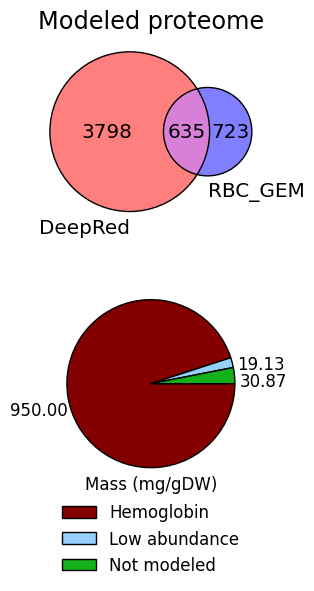

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
subsets = (
    len(dataset_proteins),
    len(model_proteins),
    len(dataset_proteins.intersection(model_proteins)),
)


venn = mpl_venn.venn2(
    subsets=subsets,
    set_labels=(dataset_name, model.id),
    set_colors=("red", "blue"),
    alpha=0.5,
    ax=ax1,
)
circles = mpl_venn.venn2_circles(
    subsets=subsets, linestyle="-", color="black", ax=ax1, linewidth=1
)
for text in venn.set_labels:
    text.set_fontsize("x-large")
for text in venn.subset_labels:
    text.set_fontsize("x-large")
ax1.set_title("Modeled proteome", fontsize="xx-large")


label_color_map = {
    "Mean hemoglobin mass modeled": ("Hemoglobin", "xkcd:dark red"),
    "Mean low abundance mass modeled": ("Low abundance", "xkcd:light blue"),
    "Mean low abundance mass remaining": ("Not modeled", "xkcd:green"),
}
edgecolor = "black"
linewidth = 1
ax2.pie(
    x=proteomes.values,
    colors=[label_color_map[k][1] for k in proteomes.index],
    pctdistance=1.35,
    counterclock=False,
    autopct=lambda pct: f"{pct * 1000/100:.2f}\n",
    textprops=dict(fontsize="large", ha="center", va="top"),
    wedgeprops=dict(edgecolor=edgecolor, linewidth=linewidth),
)
handles = [
    mpl.patches.Patch(
        edgecolor=edgecolor,
        linewidth=linewidth,
        label=label_color_map[k][0],
        facecolor=label_color_map[k][1],
    )
    for k in proteomes.index
]
ax2.legend(
    handles=handles,
    ncols=1,
    bbox_to_anchor=(0.5, 0),
    loc="upper center",
    fontsize="large",
    frameon=False,
)
ax2.set_xlabel("Mass (mg/gDW)", fontsize="large", labelpad=-10)
if save_figures:
    fig.savefig(
        results_dirpath / f"ModeledProteome.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

## Create QP model for each sample

In [20]:
def solve_qp(pcmodel, df):
    x = []  # Variables
    c = []  # Data * Weights
    F = []  # Weights

    for protdl, (data_value, weight) in df.iterrows():
        protdl = pcmodel.reactions.get_by_id(protdl)
        x.append(protdl.flux_expression)
        c.append(weight * data_value)
        F.append(weight)

    x = sympy.Matrix(x)
    c = sympy.Matrix(c)
    F = sympy.DiagMatrix(sympy.Matrix(F))
    # # QP Objective must be in form of 0.5 * x.T * F * x - c.T * x
    objective = 0.5 * x.T * F * x - c.T * x
    pcmodel.objective = objective[0]
    pcmodel.objective_direction = "min"
    pcmodel.tolerance = COBRA_CONFIGURATION.tolerance

    qp_sol = pcmodel.optimize()
    return qp_sol


def solve_qp_for_sample(
    pcmodel,
    data_measured,
    data_weights=None,
    log_zero_replacement=1e-9,
    verbose=True,
):
    # Get protein values
    data_measured = data_measured.copy()
    data_measured.name = "Measured"
    if data_weights is None:
        data_weights = pd.Series(
            [1] * len(data_measured), index=list(data_measured.index)
        )
    else:
        data_weights = data_weights.copy()
    data_weights.name = "Weights"
    df_model_protein_dilutions = create_protein_dilution_df(pcmodel)
    # Map to model
    df_model_data = (
        df_model_protein_dilutions[["PROTDL"]]
        .merge(data_measured, left_index=True, right_index=True, how="left")
        .merge(data_weights, left_index=True, right_index=True, how="left")
        .set_index("PROTDL")
        .sort_index()
    )
    # Drop data without mappings
    df = (
        df_model_data.loc[:, [data_measured.name, data_weights.name]]
        .dropna(axis=0, how="all")
        .astype(float)
    )

    # Solve QP
    with pcmodel:
        qp_sol = solve_qp(pcmodel, df)
    df_qp_sol = qp_sol.fluxes.loc[
        pcmodel.reactions.query(lambda x: isinstance(x, ProteinDilution)).list_attr(
            "id"
        )
    ]
    df_qp_sol = pd.concat(
        (df_model_data.loc[:, data_measured.name], df_qp_sol), axis=1
    ).dropna(how="all", axis=0)
    df_qp_sol = df_qp_sol.rename(
        {data_measured.name: "Measured", "fluxes": "Best-Fitted"}, axis=1
    )

    # # Fill NA measurements with 0 values for unmeasured model proteins that had a non-zero value in the best-fit.
    # # Will result in 0 value relaxation budget
    # df = df_qp_sol[df_qp_sol["Best-Fitted"] != 0]
    # df_qp_sol.loc[df[df["Measured"].isna()].index] = df_qp_sol.loc[df[df["Measured"].isna()].index].fillna(0)
    df_qp_sol = df_qp_sol.dropna(how="any", axis=0)

    obj_r2_values = {"Objective": qp_sol.objective_value}

    # Calculate R2 score
    df = df_qp_sol.copy()
    obj_r2_values["R^2"] = r2_score(
        df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average"
    )
    # Calculate R2 score on log10 transformed data
    df = df_qp_sol.apply(
        lambda x: [
            log_zero_replacement if np.isclose(y, 0, atol=log_zero_replacement) else y
            for y in x
        ]
    ).apply(np.log10)
    obj_r2_values["R^2 log10"] = r2_score(
        df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average"
    )
    # Calculate R2 score on log10 transformed data after removing 'zero' values
    df = df_qp_sol[
        ~df_qp_sol.apply(
            lambda x: np.isclose(x, 0, atol=log_zero_replacement).any(), axis=1
        )
    ].apply(np.log10)
    obj_r2_values["R^2 log10 w/o zeros"] = r2_score(
        df.iloc[:, 0].values, df.iloc[:, 1].values, multioutput="uniform_average"
    )
    handle_msg(
        "\t".join(
            [f"Sample '{sample_id}'"]
            + [f"{key}: {value:.4f}" for key, value in obj_r2_values.items()]
            + [f"#zeros: {len(df_qp_sol) - len(df):d}/{len(df_qp_sol):d}"]
        ),
        print_msg=verbose,
    )
    return (df_qp_sol, obj_r2_values)

### Set weightings for QP problem

In [21]:
# Ensure data is provided as (Protein IDs x Sample IDs)
# Use original copy number values for weights
df_weights = df_copy_numbers.T.loc[df_protein_data.index, df_samples.columns]
df_weights = 1 / df_weights.infer_objects(copy=False).replace(0, 1)
df_weights /= df_weights.mean()
df_weights

SAMPLE ID,DeepRed
Entry,
A0A024RBG1,0.039114
A0A075B6I9,0.012293
A0A075B6K5,0.302947
A0A075B6P5,0.004811
A0A075B6R9,0.059106
...,...
Q9Y6R4,1.784159
Q9Y6U3,0.281864
Q9Y6W3,0.024200


### Fit data by solving QP

In [22]:
log_zero_replacement = COBRA_CONFIGURATION.tolerance
fitting_data = {"measured": {}, "best_fit": {}, "r2_objective": {}}
qp_solutions_dict = {}
try:
    previous_fitting_data = {
        key: pd.read_csv(fitting_dirpath / f"proteome_{key}.csv", index_col=0)
        for key in list(fitting_data)
    }
except FileNotFoundError:
    # No previous data, reset
    previous_fitting_data = {key: pd.DataFrame() for key in list(fitting_data)}
if run_computations:
    for sample_id, data_measured in df_samples.items():
        # Key shouldn't matter for checking existance of previous solution
        if (
            not overwrite
            and sample_id in previous_fitting_data[list(fitting_data)[-1]].columns
        ):
            handle_msg(
                f"QP solution already obtained for {sample_id}", print_msg=verbose
            )
            for key, fitting_dict in fitting_data.items():
                fitting_dict[sample_id] = (
                    previous_fitting_data[key].loc[:, sample_id].to_dict()
                )

            df_qp_sol = pd.concat(
                (
                    previous_fitting_data["measured"].loc[:, sample_id],
                    previous_fitting_data["best_fit"].loc[:, sample_id],
                ),
                axis=1,
            ).fillna(0)
            df_qp_sol.columns = ["Measured", "Best-Fitted"]
            obj_r2_values = previous_fitting_data["r2_objective"].loc[:, sample_id]
            qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
        else:
            df_qp_sol, obj_r2_values = solve_qp_for_sample(
                pcmodel,
                data_measured,
                data_weights=df_weights.loc[:, sample_id],
                log_zero_replacement=COBRA_CONFIGURATION.tolerance,
                verbose=verbose,
            )
            fitting_data["measured"][sample_id] = df_qp_sol["Measured"].to_dict()
            fitting_data["best_fit"][sample_id] = df_qp_sol["Best-Fitted"].to_dict()
            fitting_data["r2_objective"][sample_id] = obj_r2_values
            qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
    # Save solutions to files
    for key, data in fitting_data.items():
        data = pd.DataFrame.from_dict(data, orient="columns")
        data.to_csv(fitting_dirpath / f"proteome_{key}.csv", index=True)
        fitting_data[key] = data
else:
    for key in previous_fitting_data.keys():
        fitting_data[key] = pd.read_csv(
            fitting_dirpath / f"proteome_{key}.csv", index_col=0
        )
    if len(df_samples.columns) != len(fitting_data[list(fitting_data)[-1]].columns):
        warn(
            "Number of previous solutions does not match current number of samples! May need to re-run fitting"
        )
    for sample_id in fitting_data[list(fitting_data)[-1]].columns:
        df_qp_sol = pd.concat(
            (
                fitting_data["measured"].loc[:, sample_id],
                fitting_data["best_fit"].loc[:, sample_id],
            ),
            axis=1,
        ).fillna(0)
        df_qp_sol.columns = ["Measured", "Best-Fitted"]
        obj_r2_values = fitting_data["r2_objective"].loc[:, sample_id].to_dict()
        qp_solutions_dict[sample_id] = (df_qp_sol, obj_r2_values)
handle_msg(f"Number of QP solutions: {len(qp_solutions_dict)}", print_msg=verbose)

Sample 'DeepRed'	Objective: -731.6920	R^2: 1.0000	R^2 log10: 0.9699	R^2 log10 w/o zeros: 0.9699	#zeros: 0/635
Number of QP solutions: 1


### Plot fitting

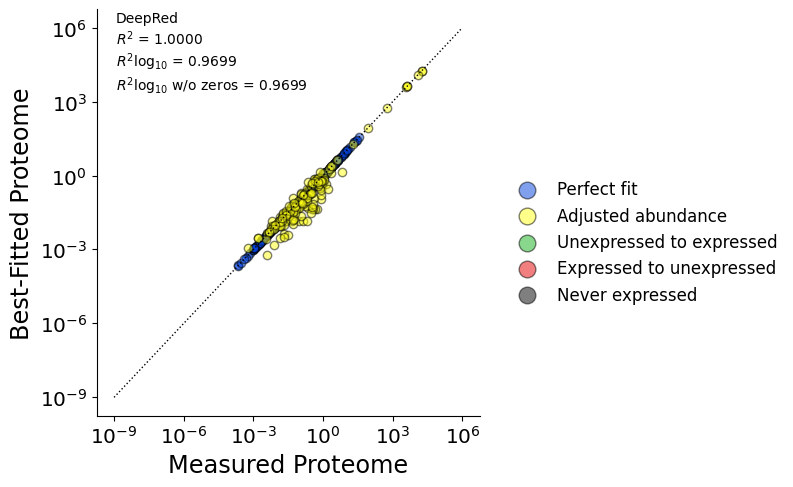

In [23]:
nrows, ncols = (1, 1)
length = 5
r2_text_loc = "upper left"
transform = False
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(length * ncols, length * nrows),
    sharex=True,
    sharey=True,
)
sns.despine(fig)

df_qp_sol, obj_r2_values = qp_solutions_dict[sample_id]
# Copy to prevent alterations to the original
df_qp_sol = df_qp_sol.copy()
xlabel, ylabel = df_qp_sol.columns

ticks = 10 ** np.arange(*np.log10([log_zero_replacement, 1e8]), 3)
if transform:
    ticks = np.log10(ticks)
    df_qp_sol.iloc[:, 0] = (
        df_qp_sol.iloc[:, 0]
        .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
        .apply(np.log10)
    )
    df_qp_sol.iloc[:, 1] = (
        df_qp_sol.iloc[:, 1]
        .apply(lambda x: log_zero_replacement if np.isclose(x, 0) else x)
        .apply(np.log10)
    )
perfect_fit_line = ax.plot(
    [ticks[0], ticks[-1]],
    [ticks[0], ticks[-1]],
    linestyle=":",
    color="black",
    linewidth=1,
    alpha=1,
)

zero_val = 0 if not transform else np.log10(log_zero_replacement)

df_zeros = df_qp_sol[(df_qp_sol.apply(lambda x: np.isclose(x, zero_val))).any(axis=1)]
df_perfect = df_qp_sol[
    np.isclose(abs(df_qp_sol["Measured"] - df_qp_sol["Best-Fitted"]), 0)
]
df_perfect = df_perfect[~df_perfect.index.isin(df_zeros.index)]

df_altered = df_qp_sol[
    ~np.isclose(abs(df_qp_sol["Measured"] - df_qp_sol["Best-Fitted"]), 0)
]
df_altered = df_altered[~df_altered.index.isin(df_zeros.index)]
df_always_zero = df_zeros[(df_zeros == zero_val).all(axis=1)]
df_zeros = df_zeros[~df_zeros.index.isin(df_always_zero.index)]
df_from_zeros = df_zeros[np.isclose(df_zeros["Measured"], zero_val)]
df_to_zeros = df_zeros[np.isclose(df_zeros["Best-Fitted"], zero_val)]

handles = [
    ax.scatter(
        data=df_perfect.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:blue",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_altered.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:yellow",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_from_zeros.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:green",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_to_zeros.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:red",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
    ax.scatter(
        data=df_always_zero.replace(0, ticks[0]),
        x=xlabel,
        y=ylabel,
        color="xkcd:black",
        alpha=0.5,
        edgecolors="black",
        linewidths=1,
    ),
]
labels = [
    f"Perfect fit",
    f"Adjusted abundance",
    f"Unexpressed to expressed",
    f"Expressed to unexpressed",
    f"Never expressed",
]

sample_label = dataset_name
if not transform:
    ax.set_xscale("log")
    ax.set_yscale("log")

fontdict = {"size": "xx-large"}
ax.set_xlabel(f"{xlabel} Proteome", fontdict=fontdict)
ax.set_ylabel(f"{ylabel} Proteome", fontdict=fontdict)

fig.legend(
    handles=handles,
    labels=labels,
    loc="center left",
    ncols=1,
    frameon=False,
    fontsize="large",
    markerscale=2,
    bbox_to_anchor=(1, 0.5),
)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.xaxis.set_tick_params(labelsize="x-large")
ax.yaxis.set_tick_params(labelsize="x-large")

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.xaxis.set_tick_params(labelsize="x-large")
ax.yaxis.set_tick_params(labelsize="x-large")

r2_format = " = {:.4f}"
r2_pos_dict = {"lower right": ((0.95, 1), "right"), "upper left": ((0.05, 0.8), "left")}
if r2_text_loc in r2_pos_dict:
    pos, ha = r2_pos_dict[r2_text_loc]
    ax.text(
        *pos,
        "\n".join(
            (
                sample_label,
                r"$R^{2}$" + r2_format.format(obj_r2_values["R^2"]),
                r"$R^{2}\text{log}_{10}$"
                + r2_format.format(obj_r2_values["R^2 log10"]),
                r"$R^{2}\text{log}_{10}\text{ w/o zeros}$"
                + r2_format.format(obj_r2_values["R^2 log10 w/o zeros"]),
            )
        ),
        transform=ax.transAxes,
        color="black",
        fontsize="medium",
        ha=ha,
    )
fig.tight_layout()
if save_figures:
    fig.savefig(
        fitting_dirpath
        / f"QPfitting_{'' if not transform else 'log10_'}{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Determine best value for slack variables

In [24]:
slack_determination_models = [dataset_name]

if run_computations:
    list_of_pcmodels = []
    for sample_id in slack_determination_models:
        df_qp_sol, _ = qp_solutions_dict[sample_id]
        # Create a copy of the model
        pcmodel_sample = pcmodel.copy()
        pcmodel_sample.id = f"{pcmodel.id}_{sample_id}"
        for protdl in pcmodel_sample.reactions.query(
            lambda x: isinstance(x, ProteinDilution)
        ):
            if protdl.id in df_qp_sol.index:
                prot_bound = df_qp_sol.loc[protdl.id]["Best-Fitted"]
            else:
                prot_bound = 0
            protdl.bounds = (float(prot_bound), float(prot_bound))
        # Add the relaxation budget with slack = 0 first
        add_relaxation_budget(pcmodel_sample, 0, int(verbose))
        list_of_pcmodels += [pcmodel_sample]

Relaxation budget added to RBC_GEM_PC_DeepRed, extra 0.0000 mg/gDW (0.0000 mg HB/gDW) from 0.0000% slack


In [25]:
slack_min = 1e-5  # Slack %
slack_max = 1.5
if run_computations:
    solutions = {
        pcmodel_sample.id: defaultdict(list) for pcmodel_sample in list_of_pcmodels
    }
    for slack_value in np.geomspace(slack_min, slack_max, 101):
        if int(verbose):
            print(f"Updating slack variable to {slack_value:.6f}.")
        for pcmodel_sample in list_of_pcmodels:
            update_slack_value(pcmodel_sample, slack_value, verbose=False)
            budget_rxn_relaxation = pcmodel_sample.reactions.get_by_id(
                f"{budget_rxn_prefix}{budget_met_prefix}relaxation"
            )
            pcmodel_sample.objective = (
                sum(
                    [
                        r.flux_expression
                        for r in pcmodel_sample.reactions.get_by_any(
                            objective_reactions
                        )
                    ]
                )
                - budget_rxn_relaxation.flux_expression
            )
            pcmodel_sample.objective_direction = "max"
            sol = pcmodel_sample.optimize()
            obj_value = sol.objective_value
            if not obj_value or np.isnan(obj_value):
                if int(verbose) > 1:
                    print(f"No solution for {100 * slack_value:.6f}%\n.")
                continue
            else:
                demand = budget_rxn_relaxation.flux
                budget = budget_rxn_relaxation.upper_bound
            solutions[pcmodel_sample.id]["model"].append(pcmodel_sample.id)
            solutions[pcmodel_sample.id]["slack"].append(slack_value)
            solutions[pcmodel_sample.id]["objective"].append(obj_value)
            solutions[pcmodel_sample.id]["_".join(objective_reactions)].append(
                sol.fluxes.loc[objective_reactions].sum()
            )
            solutions[pcmodel_sample.id]["relaxation_used_mg_per_gDW"].append(demand)
            solutions[pcmodel_sample.id]["relaxation_budget"].append(budget)
            solutions[pcmodel_sample.id]["relaxation_used_pct"].append(
                demand / budget * 100
            )
    solutions = {
        pcmodel_sample_id: pd.DataFrame.from_dict(sol)
        for pcmodel_sample_id, sol in solutions.items()
    }
    df_relaxation = pd.concat(list(solutions.values()), axis=0)
    df_relaxation.to_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.csv",
        index=False,
    )
else:
    df_relaxation = pd.read_csv(
        fitting_dirpath / f"SlackPercentDeterminationData_{model_id}.csv",
    )
    solutions = {
        mid: df_relaxation[df_relaxation["model"] == mid].drop("model", axis=1)
        for mid in df_relaxation["model"].unique()
    }
df_relaxation

Updating slack variable to 0.000010.


C:\Users\P7875\miniconda3\envs\memote-rbc-gem\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Updating slack variable to 0.000011.
Updating slack variable to 0.000013.
Updating slack variable to 0.000014.
Updating slack variable to 0.000016.
Updating slack variable to 0.000018.
Updating slack variable to 0.000020.
Updating slack variable to 0.000023.
Updating slack variable to 0.000026.
Updating slack variable to 0.000029.
Updating slack variable to 0.000033.
Updating slack variable to 0.000037.
Updating slack variable to 0.000042.
Updating slack variable to 0.000047.
Updating slack variable to 0.000053.
Updating slack variable to 0.000060.
Updating slack variable to 0.000067.
Updating slack variable to 0.000076.
Updating slack variable to 0.000085.
Updating slack variable to 0.000096.
Updating slack variable to 0.000108.
Updating slack variable to 0.000122.
Updating slack variable to 0.000138.
Updating slack variable to 0.000155.
Updating slack variable to 0.000175.
Updating slack variable to 0.000197.
Updating slack variable to 0.000222.
Updating slack variable to 0.000250.
U

,model,slack,objective,,relaxation_used_mg_per_gDW,relaxation_budget,relaxation_used_pct
0,RBC_GEM_PC_DeepRed,0.001176,-0.002365,0.0,0.002365,1.139033,0.207617
1,RBC_GEM_PC_DeepRed,0.001325,-0.002364,0.0,0.002364,1.283208,0.184262
2,RBC_GEM_PC_DeepRed,0.001493,-0.002364,0.0,0.002364,1.445633,0.163531
3,RBC_GEM_PC_DeepRed,0.001682,-0.002364,0.0,0.002364,1.628617,0.145129
4,RBC_GEM_PC_DeepRed,0.001894,-0.002363,0.0,0.002363,1.834763,0.128795
5,RBC_GEM_PC_DeepRed,0.002134,-0.002363,0.0,0.002363,2.067002,0.114296
6,RBC_GEM_PC_DeepRed,0.002404,-0.002362,0.0,0.002362,2.328637,0.101426
7,RBC_GEM_PC_DeepRed,0.002709,-0.002361,0.0,0.002361,2.623389,0.090002
8,RBC_GEM_PC_DeepRed,0.003052,-0.002360,0.0,0.002360,2.955449,0.079862
9,RBC_GEM_PC_DeepRed,0.003438,-0.002359,0.0,0.002359,3.329542,0.070861


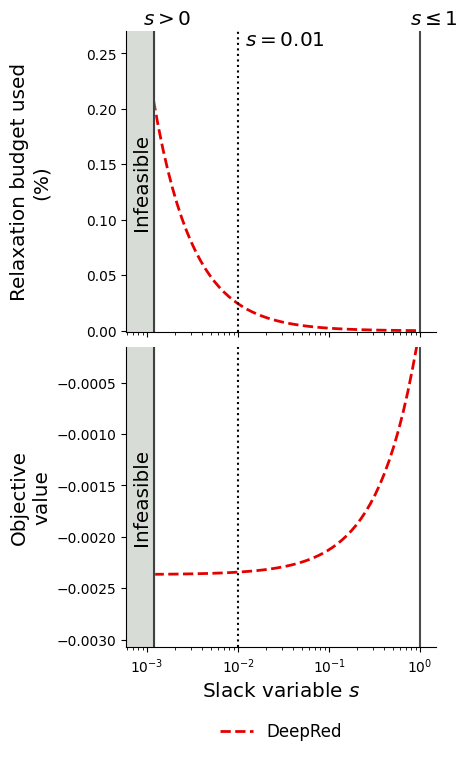

In [26]:
chosen_slack_var = 0.01
linestyle = "--"
color = "xkcd:red"

nrows = 3 if objective_reactions else 2
fig, axes = plt.subplots(
    nrows, 1, figsize=(4, nrows * 4), sharex=True, gridspec_kw=dict(hspace=0.05)
)
axes = axes.flatten()
sns.despine(fig)

o_values_min_max = (1000, -1000)
r_values_max = -1000
rxn_values_min_max = (0, -1000)

handles = []
labels = []

for pcmodel_sample_id in list(sorted(list(solutions))):
    labels.append(pcmodel_sample_id)
    s_values = solutions[str(pcmodel_sample)]["slack"].values
    r_values = solutions[str(pcmodel_sample)]["relaxation_used_pct"].values
    o_values = solutions[str(pcmodel_sample)]["objective"].values
    r_values_max = max(r_values.max(), r_values_max)
    o_values_min_max = (
        min(o_values.min(), o_values_min_max[0]),
        max(o_values.max(), o_values_min_max[-1]),
    )

    zorder = 1
    lw = 2
    axes[0].plot(
        s_values,
        r_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    axes[1].plot(
        s_values,
        o_values,
        label=str(pcmodel_sample),
        color=color,
        linestyle=linestyle,
        linewidth=lw,
        zorder=zorder,
    )
    if objective_reactions:
        rxn_values = solutions[str(pcmodel_sample)][
            "_".join(objective_reactions)
        ].values
        rxn_values_min_max = (
            min(rxn_values, rxn_values_min_max[0]),
            max(rxn_values, rxn_values_min_max[-1]),
        )

        axes[2].plot(
            s_values,
            rxn_values,
            label=str(pcmodel_sample),
            color=color,
            linestyle=linestyle,
            linewidth=lw,
            zorder=zorder,
        )

fontdict = {"size": "x-large"}
axes[-1].set_xlabel(r"Slack variable $s$", fontdict=fontdict)

zorder = 2
alpha = 0.7
limit_pad_sclar = 1.3
smin = s_values[0]

for i, ax in enumerate(axes):
    if i == 0:
        ymin, ymax = (-0.001, r_values_max * limit_pad_sclar)
    elif i == 1:
        ymin, ymax = (
            min(0, o_values_min_max[0]) * limit_pad_sclar,
            o_values_min_max[-1] * limit_pad_sclar,
        )
    elif i == 2:
        ymin, ymax = (rxn_values_min_max[0] * limit_pad_sclar, rxn_values_min_max[-1])
    else:
        pass
    ax.vlines(chosen_slack_var, ymin=ymin, ymax=ymax, color="black", linestyle=":")
    ax.vlines(
        smin,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    ax.vlines(
        1,
        ymin=ymin,
        ymax=ymax,
        color="black",
        linestyle="-",
        zorder=zorder,
        alpha=alpha,
    )
    xmin = smin / 2
    ax.set_xlim(xmin, slack_max)
    ax.set_ylim(ymin, ymax)
    ax.set_xscale("log")
    if i == 0:
        ax.annotate(
            rf"$s > 0$",
            xy=(smin, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s \leq 1$",
            xy=(1, ymax),
            xycoords="data",
            xytext=(10, 5),
            textcoords="offset points",
            ha="center",
            fontsize=fontdict["size"],
        )
        ax.annotate(
            rf"$s = {chosen_slack_var}$",
            xy=(chosen_slack_var, ymax),
            xycoords="data",
            xytext=(5, -10),
            textcoords="offset points",
            ha="left",
            fontsize=fontdict["size"],
        )
    ax.fill_between((xmin, smin), ymin, ymax, color="xkcd:light grey")
    ax.annotate(
        "Infeasible",
        xy=(smin, (ymax + ymin) / 2),
        xycoords="data",
        rotation=90,
        xytext=(-2, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        fontsize=fontdict["size"],
    )


handles, labels = axes[-1].get_legend_handles_labels()
handles_labels = dict(zip(labels, handles))
labels = [label.replace(f"{pcmodel.id}_", "").replace("_", " ") for label in labels]
axes[-1].legend(
    handles=handles,
    labels=labels,
    ncols=2,
    frameon=False,
    loc="upper center",
    fontsize="large",
    bbox_to_anchor=(0.5, -0.2),
)


axes[0].set_ylabel("Relaxation budget used\n(%)", fontdict=fontdict)
axes[1].set_ylabel("Objective\nvalue", fontdict=fontdict)
if objective_reactions:
    axes[2].set_ylabel(
        f"{'+'.join(objective_reactions)}\n(mmol/gDW/hr)", fontdict=fontdict
    )

fig.align_labels()
if save_figures:
    fig.savefig(
        fitting_dirpath / f"SlackPercentDetermination_{model_id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Formulate models from QP solutions

In [27]:
ftypes = {
    "xml"
    # "json",
}
slack_value = chosen_slack_var  # Slack %
ftypes = set([ftypes]) if isinstance(ftypes, str) else set(ftypes)
zip_kwargs = dict(compression=zipfile.ZIP_DEFLATED, compresslevel=None)


sample_pcmodels_dirpath.mkdir(exist_ok=True, parents=True)
existing_files = []
if not overwrite:
    # Check zip file for existing models
    if Path(f"{sample_pcmodels_dirpath}.zip").exists():
        with zipfile.ZipFile(f"{sample_pcmodels_dirpath}.zip", "r") as zfile:
            existing_files += [Path(x).name for x in zfile.namelist() if x]
    existing_files += [x.name for x in list(sample_pcmodels_dirpath.iterdir())]

# Check sample directory for existing files
if not len(existing_files) == len(set(existing_files)):
    raise ValueError(
        f"Duplicates found: {[k for k, v in Counter(existing_files).items() if v > 1]}"
    )
existing_files = set(sorted(existing_files))


for sample_id, (df_qp_sol, _) in qp_solutions_dict.items():
    sample_id = f"{pcmodel.id}_{sample_id}"
    filenames = [f"{sample_id}.{ftype}" for ftype in ftypes]
    if all([fname in existing_files for fname in filenames]):
        handle_msg(f"Model(s) already created for {sample_id}", print_msg=verbose)
        continue
    pcmodel_sample = pcmodel.copy()
    pcmodel_sample.id = sample_id
    for protdl in pcmodel_sample.reactions.query(
        lambda x: isinstance(x, ProteinDilution)
    ):
        prot_bound = (
            df_qp_sol.loc[protdl.id]["Best-Fitted"]
            if protdl.id in df_qp_sol.index
            else 0
        )
        protdl.bounds = (float(prot_bound), float(prot_bound))

    # Add the relaxation budget
    add_relaxation_budget(pcmodel_sample, slack_value, verbose=False)
    budget_rxn_relaxation = pcmodel_sample.reactions.get_by_id(
        f"{budget_rxn_prefix}{budget_met_prefix}relaxation"
    )
    # Determine smallest allowable relxation budget for simulation capabilities
    with pcmodel_sample:
        pcmodel_sample.objective = budget_rxn_relaxation.flux_expression
        pcmodel_sample.objective_direction = "min"
        budget_min = pcmodel_sample.slim_optimize()
    budget_rxn_relaxation.lower_bound = budget_min
    for filename in filenames:
        # Might as well overwrite all files, especially if model needed to be regenerated anyways
        write_cobra_model(
            pcmodel_sample,
            filename=sample_pcmodels_dirpath / filename,
        )

    handle_msg(f"Model(s) saved for {pcmodel_sample.id}", print_msg=verbose)

dirpath = sample_pcmodels_dirpath
with tempfile.TemporaryDirectory() as tmpdir:
    if not overwrite and Path(f"{dirpath}.zip").exists():
        handle_msg("Copying original zip to temporary directory", print_msg=verbose)
        shutil.copy(f"{dirpath}.zip", tmpdir)
    handle_msg("Appending model files to temporary zip file", print_msg=verbose)
    with zipfile.ZipFile(f"{tmpdir}/{dirpath.name}.zip", "a", **zip_kwargs) as zfile:
        existing_files = set([Path(x).name for x in zfile.namelist() if x])
        for filename in list(dirpath.iterdir()):
            if filename.name in existing_files:
                continue
            zfile.write(f"{filename}", arcname=f"{filename.name}")
    # Replacing original directory
    handle_msg("Setting temporary zip file as the new zip file", print_msg=verbose)
    shutil.copy(f"{tmpdir}/{dirpath.name}.zip", dirpath.parent)
handle_msg("Finished compression, cleaning up files", print_msg=verbose)
shutil.rmtree(str(dirpath))
handle_msg("Finished cleanup", print_msg=verbose)

Model(s) saved for RBC_GEM_PC_DeepRed
Appending model files to temporary zip file
Setting temporary zip file as the new zip file
Finished compression, cleaning up files
Finished cleanup
